
# Análisis de Cuantiles 
## (Q1/Q2/Q3), IQR, Outliers y Boxplots — Pandas & Polars

**Objetivos:**  
1) Calcular **Q1, Q2 (mediana)** y **Q3**.  
2) Obtener el **IQR**.  
3) Identificar **outliers** con la regla de 1.5×IQR.  
4) Visualizar con **boxplots**.  
5) (Opcional) Repetir con **Polars** para datasets grandes.

> El notebook intenta leer `ventas_100.csv` del directorio de trabajo.  
> Si no lo encuentra, genera un **dataset sintético** reproducible para que todo se ejecute igual.


🔹 Concepto estadístico: cuartil y cuantiles

En resumen, la función quantile(q=0.25) devuelve el primer cuartil (Q1) de los datos en cada columna (o fila) del DataFrame, usando por defecto el método de interpolación lineal.

Significado: Q1 es el valor por debajo del cual se encuentra el 25% de los datos. Es una medida de posición que nos ayuda a entender la dispersión y la tendencia central de los datos, y es ampliamente usado en estadística para resumir datos y en boxplots para definir el bigote inferior.

Nota: Si el DataFrame tiene valores faltantes (NaN), por defecto los omitirá en el cálculo, a menos que se especifique lo contrario.

Formalmente:

Q(q)=el valor tal que P(X≤Q(q))=q

Esto significa que el 25% de los valores de la variable son menores o iguales a ese valor, y el 75% son mayores.
Es una medida no paramétrica de tendencia y dispersión, que no depende de supuestos de normalidad.

🔹 En términos prácticos

Si tienes una serie de datos numéricos, por ejemplo:

```python
import pandas as pd

s = pd.Series([10, 20, 30, 40, 50])
s.quantile(q=0.25)
```

El resultado será 20.0, porque el 25% de los valores se encuentran por debajo de 20 (en este caso, entre 10 y 20, interpolando si es necesario).

🔹 Métodos de interpolación

La función permite especificar cómo se interpola cuando el cuantil no coincide exactamente con un índice de la muestra.

Por ejemplo:
```python
df.quantile(0.25, interpolation='linear')
```

Opciones comunes para interpolación:
- 'linear' (por defecto): interpola entre los dos valores más cercanos.
- 'lower': usa el valor más bajo.
- 'higher': usa el valor más alto.
- 'midpoint': promedio de ambos.
- 'nearest': el valor más cercano.

Esto es importante cuando trabajas con muestras pequeñas o datos discretos.

🔹 En el contexto de análisis estadístico

El cuantil del 25% (Q1) es una medida clave:

- Se usa para detectar asimetrías y dispersión.
- Permite calcular el rango intercuartílico (IQR):

IQR=Q3−Q1=quantile(0.75)−quantile(0.25)

- que mide la variabilidad central sin verse afectada por valores extremos.
- En boxplots, Q1 es el límite inferior de la caja.


```python
# Por columnas (axis=0 - default)
q1_columnas = df_completo.quantile(0.25, axis=0)

# Por filas (axis=1)
q1_filas = df_completo.quantile(0.25, axis=1)
print("Q1 por filas:")
print(q1_filas)
```

In [2]:
import os
import pandas as pd
import numpy as np

# Parámetros
CSV_PATH = "ventas_100.csv"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def build_synthetic_df(n=500):
    # Datos sintéticos plausibles inspirados en un dataset inmobiliario/comercial
    ventas   = np.random.lognormal(mean=12.4, sigma=0.55, size=n)        # ~ precio en CLP
    clientes = np.random.randint(1, 30, size=n)                           # conteo de clientes
    metros   = np.random.normal(loc=55, scale=15, size=n).clip(20, 180)   # superficie
    edad     = np.random.normal(loc=38, scale=12, size=n).clip(18, 85)    # edad cliente
    ingreso  = np.random.lognormal(mean=14.2, sigma=0.6, size=n)          # ingresos CLP

    # Inyectar algunos outliers
    ventas[:5] *= 8
    ingreso[5:10] *= 10

    return pd.DataFrame({
        "ventas": ventas,
        "clientes": clientes,
        "metros": metros,
        "edad": edad,
        "ingreso": ingreso
    })

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    source = f"Archivo encontrado: {CSV_PATH}"
else:
    df = build_synthetic_df(800)
    source = "Fuente: dataset sintético (no se encontró ventas_100.csv)."

# Filtrar columnas numéricas
df_num = df.select_dtypes(include=['number'])

print(source)
df_num.head()


Fuente: dataset sintético (no se encontró ventas_100.csv).


,ventas,clientes,metros,edad,ingreso
0,2.552629e+06,18,60.109000,61.528295,5.442495e+05
1,1.800178e+06,27,76.527723,51.528299,2.029457e+06
2,2.773638e+06,10,63.466045,32.625026,1.608265e+06
3,4.488854e+06,7,60.333259,22.690015,2.324849e+06
4,1.707699e+06,17,29.728219,37.638269,5.173943e+05


## Descripción inicial (percentiles incluidos)

In [3]:

desc = df_num.describe(percentiles=[0.25, 0.5, 0.75]).T
desc


,count,mean,std,min,25%,50%,75%,max
ventas,800.0,2.954966e+05,2.678102e+05,40835.331874,165002.577851,2.449713e+05,3.439276e+05,4.488854e+06
clientes,800.0,1.505625e+01,8.457245e+00,1.000000,8.000000,1.500000e+01,2.300000e+01,2.900000e+01
metros,800.0,5.471512e+01,1.481238e+01,20.000000,44.372878,5.516916e+01,6.466065e+01,9.596301e+01
edad,800.0,3.833759e+01,1.132097e+01,18.000000,29.747388,3.829892e+01,4.645568e+01,7.474336e+01
ingreso,800.0,1.820317e+06,1.840017e+06,199814.870240,961296.598839,1.409356e+06,2.175699e+06,2.864039e+07


## Cálculo explícito de Q1, Q2 y Q3, e IQR

In [4]:

Q1 = df_num.quantile(0.25)
Q2 = df_num.quantile(0.50)  # mediana
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

quantile_summary = pd.DataFrame({
    "Q1 (25%)": Q1,
    "Q2 (50%)": Q2,
    "Q3 (75%)": Q3,
    "IQR": IQR
})
quantile_summary


,Q1 (25%),Q2 (50%),Q3 (75%),IQR
ventas,165002.577851,2.449713e+05,3.439276e+05,1.789250e+05
clientes,8.000000,1.500000e+01,2.300000e+01,1.500000e+01
metros,44.372878,5.516916e+01,6.466065e+01,2.028777e+01
edad,29.747388,3.829892e+01,4.645568e+01,1.670830e+01
ingreso,961296.598839,1.409356e+06,2.175699e+06,1.214402e+06


## Detección de outliers vía regla 1.5×IQR

In [5]:

outlier_counts = {}
bounds = {}

for col in df_num.columns:
    q1, q3, iqr = Q1[col], Q3[col], IQR[col]
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[col] = (lower, upper)
    outlier_counts[col] = int(((df_num[col] < lower) | (df_num[col] > upper)).sum())

outlier_summary = pd.DataFrame({
    "LowerBound": {k: v[0] for k, v in bounds.items()},
    "UpperBound": {k: v[1] for k, v in bounds.items()},
    "Outliers": outlier_counts
})
outlier_summary


,LowerBound,UpperBound,Outliers
ventas,-103384.941404,6.123151e+05,43
clientes,-14.500000,4.550000e+01,0
metros,13.941221,9.509231e+01,3
edad,4.684945,7.151813e+01,1
ingreso,-860307.081952,3.997303e+06,40


## Boxplots (Pandas + Matplotlib)

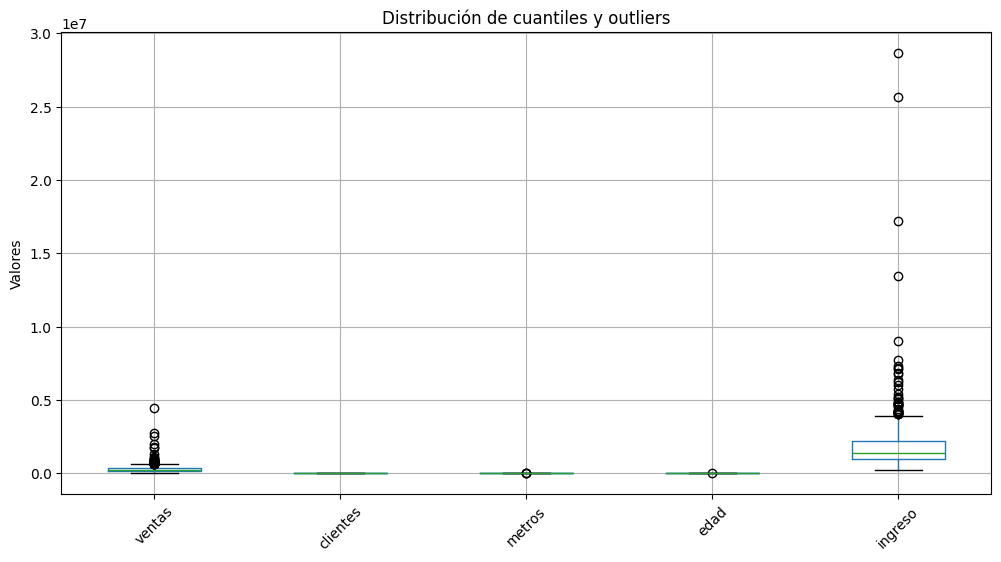

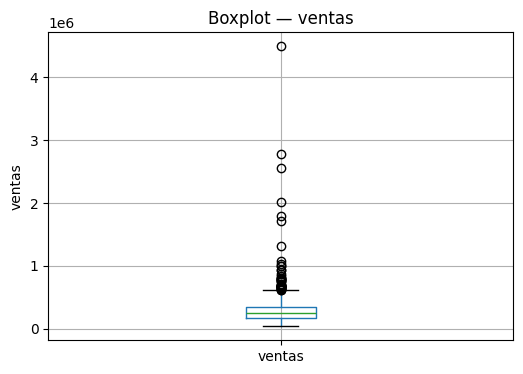

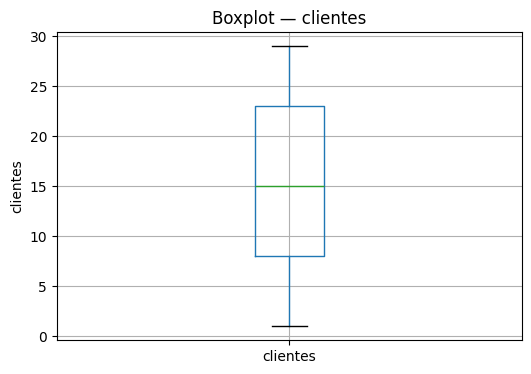

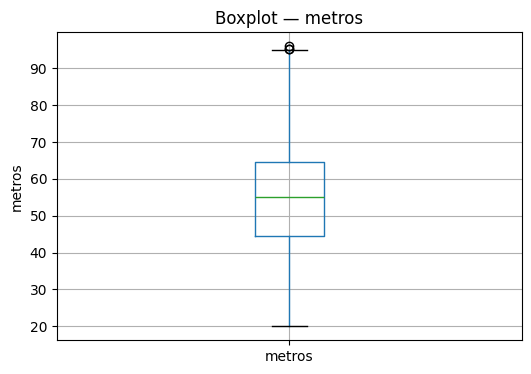

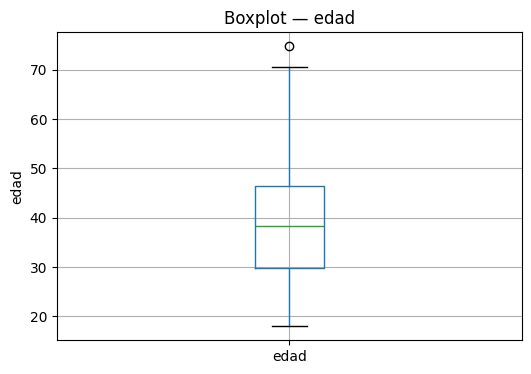

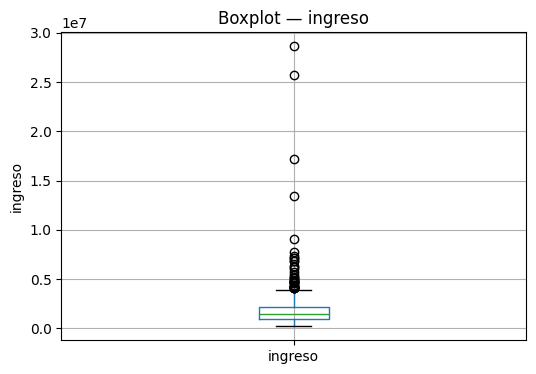

In [6]:

import matplotlib.pyplot as plt

# Boxplot general
plt.figure(figsize=(12, 6))
df_num.boxplot()
plt.title("Distribución de cuantiles y outliers")
plt.ylabel("Valores")
plt.xticks(rotation=45)
plt.show()

# Boxplots individuales por columna (útil para escalas muy distintas)
for col in df_num.columns:
    plt.figure(figsize=(6, 4))
    df_num[[col]].boxplot()
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.xticks(rotation=0)
    plt.show()



## Interpretación y uso analítico

- **Q1 (25%)**: valor bajo el cual cae el 25% de la distribución.  
- **Q2 (50%) / Mediana**: tendencia central robusta.  
- **Q3 (75%)**: límite superior del rango central.  
- **IQR = Q3 - Q1**: variabilidad central sin impacto de outliers.  
- **Outliers** (regla 1.5×IQR): candidatos a revisión (errores, casos especiales, segmentos premium).

### Recomendaciones prácticas (precio/ingreso/metros, etc.)
- IQR alto → alta heterogeneidad del portafolio; segmenta o normaliza.  
- Asimetría (Q3 muy alejado de Q2) → evalúa transformaciones (log) o métricas robustas (mediana, MAD).  
- Outliers frecuentes → valida calidad de datos, caps/winsorization, reglas de negocio.
